# <div style="text-align: center">18.335/6.337 Problem Set 5 - CG, LU, and Cholesky</div>
## <div style="text-align: center">Solution</div>
### <div style="text-align: center">Created by Wonseok Shin</div>

$\newcommand{\Cmat}[2]{\mathbb{C}^{#1\times#2}}\newcommand{\Cvec}[1]{\mathbb{C}^{#1}}\newcommand{\Rmat}[2]{\mathbb{R}^{#1\times#2}}\newcommand{\Rvec}[1]{\mathbb{R}^{#1}}\newcommand{\null}{\mathrm{null}}\newcommand{\range}{\mathrm{range}}\newcommand{\rank}{\mathrm{rank}}\newcommand{\nullity}{\mathrm{nullity}}\newcommand{\sign}{\mathrm{sign}}\newcommand{\norm}[1]{\left\|#1\right\|}\newcommand{\abs}[1]{\left|#1\right|}\newcommand{\epsmach}{\epsilon_\mathrm{machine}}\newcommand{\log}{\mathrm{log}}\newcommand{\tanh}{\mathrm{tanh}}\newcommand{\l}{\lambda}\newcommand{\d}{\delta}$

## Problem 1.  CG [5 pts]

In this problem, we will implement CG.  Unlike GMRES, CG uses a short-term recurrence relationship, so its memory usage stays constant throughout the entire iteration.  Therefore, we can use CG to solve much larger linear systems, for which the relative efficiency of iterative solvers compared to direct solvers is greater.  In fact, we will see that for such systems, our crude implementation of CG is indeed much faster than the highly optimized direct solver.

### Assignment 1.1.  `cg!` [2 pts]

Complete `cg!` below that performs CG to solve $A x = b$.  The function takes exactly the same input (`A`, `b`, `x`, `tol`, `nmax`) and output (`n`, `relres`) parameters as `gmres!` of the previous problem set.

Make sure to write the function such that it accepts an arbitrary initial guess solution $x_0$.  The pseudocode introduced by Professor Edelman assumed $x_0 = 0$, but you can easily transform the pseudocode for an arbitrary $x_0$ by using $r_0 = b - A x_0$ instead of $r_0 = b$ as the initial residual vector.

Because we want to make `cg!` really efficient, here are a few tips for performance enhancement:

- We need to perform `w = A*v` for some vectors `v` at every iteration step, but `A*v` allocates a new array everytime it is called.  To avoid this expensive array allocation, preallocate an output array `w` outside the iteration loop and use `A_mul_B!(w, A, v)` instead; see the [documentation](https://docs.julialang.org/en/stable/stdlib/linalg/#Base.A_mul_B!).
- Use the [dot syntax](https://julialang.org/blog/2017/01/moredots) when updating a vector in order to avoid allocation of temporary vectors (e.g., use `y .+= α.*x` instead of `y += α*x`).

In [1]:
function cg!(A, b, x, tol=1e-6, nmax=length(b))
    r = A*x
    r .= b .- r
    p = copy(r)
    
    lb = norm(b)
    
    rr = sum(abs2, r)
    r2b = sqrt(rr) / lb
    relres = zeros(nmax+1)  # one more space to store ‖r₀‖ / ‖b‖
    relres[1] = r2b
    
    Ap = similar(x)
    n = 0
    while n < nmax && r2b > tol
        n += 1

        A_mul_B!(Ap, A, p)  # Ap = A*p
        pAp = p⋅Ap
        
        α = rr / pAp
        x .+= α.*p
        
        β = rr  # will be updated later
        r .-= α.*Ap
        
        rr = sum(abs2, r)
        β = rr / β

        p .= r .+ β.*p
        
        r2b = sqrt(rr) / lb
        relres[n+1] = r2b
    end

    return n, relres
end

cg! (generic function with 3 methods)

### Validation of your implementation

Now, let's validate your implementation of `cg!` by solving 2D Poisson's equation $-\nabla^2 u(x,y) = f(x,y)$, whose operator happens to be Hermitian positive-definite and therefore is suitable for CG.

The function `poisson2d` that constructs a sparse matrix for 2D Poisson's equation is provided below for you.  Also provided is a script that solves Poisson's equation using `poisson2d` and `cg!` and plots the convergence curve and solution.  Run this script to see if your `cg!` produces a matching convergence curve with the reference curve.  Also see if your numerical solution to 2D Poisson's equation makes sense.  (It must have a singularity at the center of the $xy$ domain.)

In [2]:
function poisson2d(∆x, ∆y, Nx, Ny)
    N = Nx*Ny
    ∆x⁻², ∆y⁻² = 1.0/∆x^2, 1.0/∆y^2
    row₀ = reshape(1:N, (Nx,Ny)); col₀ = row₀; val₀ = 2.0(∆x⁻² + ∆y⁻²)  # diagonal

    rowx₊ = row₀[1:end-1,:]; colx₊ = circshift(col₀, (-1,0))[1:end-1,:]; valx₊ = -∆x⁻²  # superdiagonal
    rowx₋ = row₀[2:end,:]; colx₋ = circshift(col₀, (1,0))[2:end,:]; valx₋ = -∆x⁻²  # subdiagonal
    rowy₊ = row₀[:,1:end-1]; coly₊ = circshift(col₀, (0,-1))[:,1:end-1]; valy₊ = -∆y⁻²  # farthest superdiagonal
    rowy₋ = row₀[:,2:end]; coly₋ = circshift(col₀, (0,1))[:,2:end]; valy₋ = -∆y⁻²  # farthest subdiagonal
    
    A = sparse(row₀[:], col₀[:], val₀, N, N) +  # diagonal
        sparse(rowx₊[:], colx₊[:], valx₊, N, N) +  # superdiagonal
        sparse(rowx₋[:], colx₋[:], valx₋, N, N) +  # subdiagonal
        sparse(rowy₊[:], coly₊[:], valy₊, N, N) +  # farthest superdiagonal
        sparse(rowy₋[:], coly₋[:], valy₋, N, N)  # farthest subdiagonal

    return A
end

poisson2d (generic function with 1 method)

  0.443561 seconds (202.90 k allocations: 10.092 MiB, 1.62% gc time)


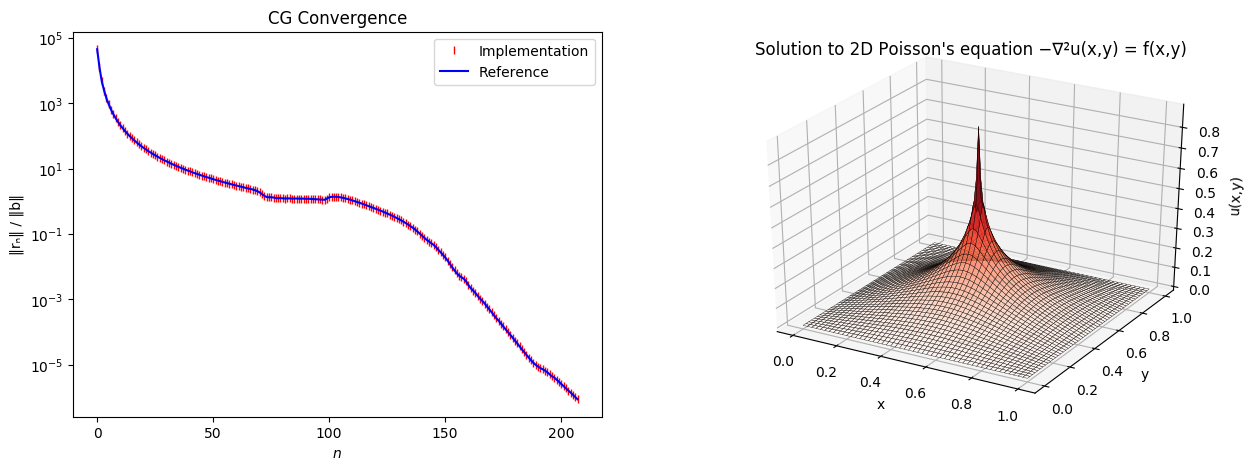

PyObject <matplotlib.text.Text object at 0x136940390>

In [3]:
# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01

A = poisson2d(∆x, ∆y, Nx, Ny)

f = zeros(Nx, Ny)
f[cld(Nx,2), cld(Ny,2)] = 1e4

b = f[:]

# Solve the equation by CG.
x = copy(b)
@time n1, relres1 = cg!(A, b, x)

# Prepare plot data.
u = zeros(Nx+2, Ny+2)
u[2:Nx+1, 2:Ny+1] = reshape(x, (Nx,Ny))  # x is solution off-boundary

xs = (0:Nx+1)*∆x .+ zeros(Ny+2)'  # (Nx+2) by (Ny+2)
ys = (0:Ny+1)'*∆y .+ zeros(Nx+2)  # (Nx+2) by (Ny+2)

# Plot the convergence behavior and the solution.
using PyPlot
figure(figsize=(15,5))

using JLD
@load "bench_cg.jld"  # load reference relres
n = findlast(relres .> 0) - 1

subplot(121)
semilogy(0:n1, relres1[1:n1+1], "r|", 0:n, relres[1:n+1], "b-")
title("CG Convergence")
xlabel(L"n")
ylabel("‖rₙ‖ / ‖b‖")
legend(["Implementation", "Reference"], loc="upper right")

PyPlot.PyObject(PyPlot.axes3D)
subplot(122, projection="3d")
plot_surface(xs, ys, u, rstride=2,edgecolors="k", cstride=2, cmap="Reds", alpha=0.8, linewidth=0.25)
title("Solution to 2D Poisson's equation −∇²u(x,y) = f(x,y)")
xlabel("x")
ylabel("y")
zlabel("u(x,y)")

### Assignment 1.2.  CG vs. a direct solver [0.5 pts]

We learned that iterative methods can be much faster than direct methods, especially if the matrix is sparse.  Can our suboptimal implementation of CG beat the highly optimized Julia's backslash (`\`) operator?  Let's figure it out.

Complete the following code block that measures time taken by CG and the backslash operator to solve the same 2D Poisson's equation.  To eliminate outliers, we solve the equation 20 times and take the median.

Make sure to initialize `x` before feeding it to `cg!`.  If you feed the solution from the previous trial, `cg!` finishes in zero step.

In [4]:
Ntrial = 20
t_cg = zeros(Ntrial)
t_div = zeros(Ntrial)

# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01

A = poisson2d(∆x, ∆y, Nx, Ny)

f = zeros(Nx, Ny)
f[cld(Nx,2), cld(Ny,2)] = 1e4

b = f[:]

# Measure solution times.
for k = 1:Ntrial
    x = zeros(N)
    t_cg[k] = @elapsed cg!(A, b, x)
    t_div[k] = @elapsed A\b
end

@printf "CG is %.2f times faster than backslash." median(t_div)/median(t_cg)

CG is 1.51 times faster than backslash.

### Assignment 1.3.  Matrix-free formulation [2 pts]

Iterative methods use the matrix $A$ only when performing the matrix-vector multiplication $A x$ for some vectors $x$.  Therefore, if we can implement a function that performs the matrix-vector multiplication $A x$ without explicitly constructing the matrix $A$, such a function can be used to implement iterative methods.  This is called the "matrix-free formulation".

The function `apply_poisson2d!` provided below is exactly such a function.  It takes an $N_x \times N_y$ array `u` (like the solution $u(x,y)$ of 2D Poisson's equation), applies the negative Laplacian $-\nabla^2$ to `u`, and stores the result in a $N_x \times N_y$ array `f` (like $f(x,y) = -\nabla^2 u(x,y)$).  The function performs this operation simply by adding and subtracting neighboring entries of `u`, without constructing a matrix.

Complete `cg2d!` below that implements the matrix-free version of `cg!`.  It takes a function `applyA!` instead of the matrix `A`.  Inside `cg2d!`, `applyA!` is used as `applyA!(f,u)` to perform the matrix-vector multiplication $f = A u$ without explicitly constructing the matrix $A$.  The subsequent validation code shows how to define `applyA!` using `apply_poisson2d!`.

You may want to use `vecdot`.  `vecdot(v,w)` works for *arrays* `v` and `w`, and it basically generates `v[:]'*w[:]`.

In [5]:
function apply_poisson2d!(f, u, ∆x, ∆y)
    Nx, Ny = size(u)
    ∆x⁻², ∆y⁻² = 1.0/∆x^2, 1.0/∆y^2
    
    for i = 1:Nx
        @inbounds f[i,1] = (2u[i,1] - u[i,2]) * ∆y⁻²  # j = 1
        @inbounds f[i,Ny] = (2u[i,Ny] - u[i,Ny-1]) * ∆y⁻²  # j = Ny
    end
    
    for j = 2:Ny-1, i = 1:Nx
        @inbounds f[i,j] = (2u[i,j] - u[i,j+1] - u[i,j-1]) * ∆y⁻²  # 2 ≤ j ≤ Ny-1
    end
    
    for j = 1:Ny
        @inbounds f[1,j] += (2u[1,j] - u[2,j]) * ∆x⁻²  # i = 1
        @inbounds f[Nx,j] += (2u[Nx,j] - u[Nx-1,j]) * ∆x⁻²  # i = Nx
    end

    for j = 1:Ny, i = 2:Nx-1
        @inbounds f[i,j] += (2u[i,j] - u[i+1,j] - u[i-1,j]) * ∆x⁻²  # 2 ≤ i ≤ Nx-1
    end
end

apply_poisson2d! (generic function with 1 method)

In [6]:
function cg2d!(applyA!, b, x, τ=1e-6, nmax=length(b))
    r = similar(x)
    applyA!(r, x)  # r = A*x

    r .= b .- r
    
    p = copy(r)
    
    lb = sqrt(sum(abs2,b))
    
    rr = sum(abs2, r)
    r2b = sqrt(rr) / lb
    relres = zeros(nmax+1)  # one more space to store ‖r₀‖ / ‖b‖
    relres[1] = r2b
    
    Ap = similar(x)
    n = 0
    while n < nmax && r2b ≥ τ
        n += 1

        applyA!(Ap, p)
        pAp = vecdot(p, Ap)

        α = rr / pAp
        x .+= α.*p

        β = rr  # will be updated later
        r .-= α.*Ap

        rr = sum(abs2, r)
        β = rr / β

        p .= r .+ β.*p

        r2b = sqrt(rr) / lb
        relres[n+1] = r2b
    end

    return n, relres
end

cg2d! (generic function with 3 methods)

### Validation of your implementation

The following code block performs the same validation as before, but uses `cg2d!` instead of `cg!`.

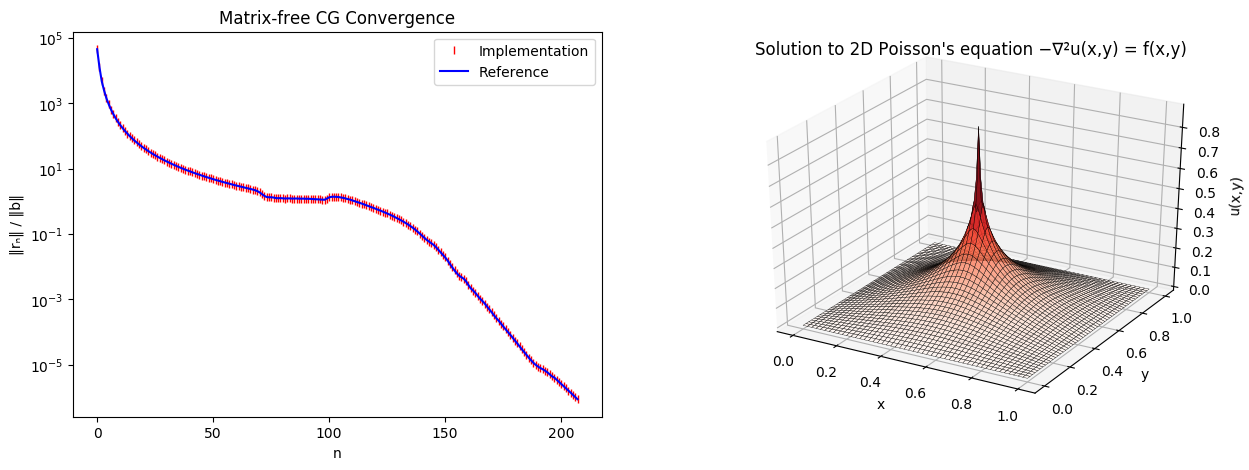

PyObject <matplotlib.text.Text object at 0x139d6a240>

In [7]:
# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01

applyA!(f, u) = apply_poisson2d!(f, u, ∆x, ∆y)

b = zeros(Nx, Ny)
b[cld(Nx,2), cld(Ny,2)] = 1e4

# Solve the equation by matrix-free CG.
x = copy(b)
n1, relres1 = cg2d!(applyA!, b, x)

# Prepare plot data.
u = zeros(Nx+2, Ny+2)
u[2:Nx+1, 2:Ny+1] = x

xs = (0:Nx+1)*∆x .+ zeros(Ny+2)'
ys = (0:Ny+1)'*∆y .+ zeros(Nx+2)

# Plot the convergence behavior and the solution.
using PyPlot
figure(figsize=(15,5))

using JLD
@load "bench_cg.jld"  # load relres
n = findlast(relres .> 0) - 1

subplot(121)
semilogy(0:n1, relres1[1:n1+1], "r|", 0:n, relres[1:n+1], "b-")
title("Matrix-free CG Convergence")
xlabel("n")
ylabel("‖rₙ‖ / ‖b‖")
legend(["Implementation", "Reference"], loc="upper right")

PyPlot.PyObject(PyPlot.axes3D)
subplot(122, projection="3d")
plot_surface(xs, ys, u, rstride=2,edgecolors="k", cstride=2, cmap="Reds", alpha=0.8, linewidth=0.25)
title("Solution to 2D Poisson's equation −∇²u(x,y) = f(x,y)")
xlabel("x")
ylabel("y")
zlabel("u(x,y)")

### Assignment 1.4.  Matrix-free CG vs. a direct solver [0.5 pts]

Repeat Assignment 2.2 for `cg2d!`.  Is `cg2d!` faster than `cg!`?

In [8]:
# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01

applyA!(f, u) = apply_poisson2d!(f, u, ∆x, ∆y)

f = zeros(Nx, Ny)
f[cld(Nx,2), cld(Ny,2)] = 1e4

b = f[:]

# Measure solution times.
Ntrial = 20
t_cg = zeros(Ntrial)
t_div = zeros(Ntrial)

for k = 1:Ntrial
    u = zeros(Nx, Ny)
    t_cg[k] = @elapsed cg2d!(applyA!, f, u)
    t_div[k] = @elapsed A\b
end

@printf "Matrix-free CG is %.2f times faster than backslash." median(t_div)/median(t_cg)

Matrix-free CG is 5.00 times faster than backslash.

## Problem 2.  LU factorization [2 pts]

In this problem, we will implement the LU factorization algorithm.  Also, we will consider its simplification for matrices with a special structure, namely tridiagonal matrices.

### Assignment 2.1.  `lu!` [0.5 pts]

(Inspired by Exercise 20.4 of T&B)

Complete `lu!` below that performs the LU factorization (without pivoting) using only one explicit for loop.  This function must perform the LU factorization in-place. 

After executing `lu!(A)` for a square matrix $A$,

- the upper triangular portion (including the main diagonal) stores the $U$ factor, and
- the *strictly* lower triangular portion (excluding the main diagonal) stores the strictly lower triangular portion of the $L$ factor.

The main diagonal portion of $L$ doesn't have to be stored, because we know it is filled with $1$.

In [9]:
function lu!(A)
    m, n = size(A)
    assert(m==n)
    for k = 1:m-1
        A[k+1:m, k] ./= A[k,k]
        A[k+1:m, k+1:m] -= @view(A[k+1:m, k]) * @view(A[k:k, k+1:m])
    end
    
    return nothing
end

lu! (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of the function.

In [10]:
A = rand(Complex128,10,10)

LU = copy(A)
lu!(LU)

L = tril(LU)
L[diagind(L)] .= 1

U = triu(LU)

println("L U ≈ A? $(L*U ≈ A)")

L U ≈ A? true


### Assignment 2.2.  Thomas algorithm [1 pt]

The Thomas algorithm is simplification of the LU factorization for tridiagonal matrices.  

One version of the Thomas algorithm is described [here](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm), but it differs from our LU factorization in that it fills the main diagonal of $U$ (instead of $L$) with $1$'s.  In this assignment, we will modify this algorithm such that the main diagonal of $L$ is filled with $1$'s, like the $L$ factor of the LU factorization.

Complete `thomas!` below that applies such a modified Thomas algorithm to a tridiagonal matrix $A\in\Cmat{m}{m}$ in-place.  You can easily "invent" this algorithm by applying the LU factorization to a tridiagonal matrix.  The function takes three input arguments:

- `l` is a length-$(m-1)$ vector containing the subdiagonal of $A$,
- `d` is a length-$m$ vector containing the main diagonal of $A$, and
- `u` is a length-$(m-1)$ vector containing the superdiagonal of $A$.

After executing `thomas!(l, d, u)`, 

- `l` stores the subdiagonal of $L$, and 
- `d` and `u` store the main and superdiagonal of $U$.

It turns out that all the other entries of $L$ and $U$ are zeros except for the above $l$, $d$, $u$, and the main diagonal of $L$ (which is filled with $1$'s).

In [11]:
function thomas!(l, d, u)
    m = length(d)
    for j = 1:m-1
        l[j] /= d[j]
        d[j+1] -= l[j]*u[j]
    end
    
    return nothing
end

thomas! (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of the function.

In [12]:
m = 10
l = rand(Complex128, m-1)
d = rand(Complex128, m)
u = rand(Complex128, m-1)
A = copy(Tridiagonal(l, d, u))

thomas!(l, d, u)

L = Bidiagonal(ones(m), l, 'L')
U = Bidiagonal(d, u, 'U')

println("L U ≈ A? $(L*U ≈ A)")

L U ≈ A? true


### Assignment 2.3.  `subs_thomas!` [0.5 pts]

Now that we have the information $l$, $d$, and $u$ of the LU factors of a tridiagonal $A$, let's use them in solving $A x = b$.

Complete `subs_thomas!` below that uses forward and back substitution internally to solve $A x =  b$.  The function takes four arguments:

- `l`, `d`, `u` are constructed by `thomas!` and store the information about the LU factorization of a tridiagonal $A$, and
- `b` is the right-hand-side vector $b$ of $A x = b$.

After executing `subs_thomas!(l, d, u, b)`, 

- `l`, `d`, `u` remain the same as before, and
- `b` stores the solution $x$.

In [13]:
function subs_thomas!(l, d, u, b)
    m = length(d)
    y = b
    for i = 2:m
        y[i] -= l[i-1]*y[i-1]
    end
    
    x = y
    x[m] /= d[m]
    for i = m-1:-1:1
        x[i] -= u[i]*x[i+1]
        x[i] /= d[i]
    end
    
    return nothing
end

subs_thomas! (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of the function.

In [14]:
m = 10
l = rand(Complex128, m-1)
d = rand(Complex128, m)
u = rand(Complex128, m-1)
A = copy(Tridiagonal(l, d, u))

thomas!(l, d, u)

b = rand(Complex128, m)
x = copy(b)
subs_thomas!(l, d, u, x)

println("x ≈ A\\b? $(x ≈ A\b)")

x ≈ A\b? true


## Problem 3.  Cholesky factorization and ICC [3 pts]

In this problem, we will implement the Cholesky factorization and incomplete Cholesky (ICC) factorization algorithms.

### Assignment 3.1.  `chol!` [0.5 pts]

Complete `chol!` below that performs the Cholesky factorization $A = C C^*$ in-place on a Hermitian positive-definite matrix $A \in \Cmat{m}{m}$.

The function takes only one argument `A`.  After executing `chol!(A)`, the lower and upper triangular portions of `A` store the Cholesky factor $C$ and $C^*$, respectively.  Note that storing $C$ and $C^*$ simultaneously in $A$ is possible becouse $C$ and $C^*$ have the same diagonal.

In [15]:
function chol!(A)
    m = size(A,1)   
    for k = 1:m
        A[k,k] = sqrt(A[k,k])
        for i = k+1:m
            A[i,k] /= A[k,k]
            A[k,i] = conj(A[i,k])
            for j = k+1:i
                A[i,j] -= A[i,k]*conj(A[j,k])
                # A[j,i] = conj(A[i,j]) is not needed.
            end
        end
    end
    
    return nothing
end    

chol! (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of the function.

In [16]:
m = 10
B = rand(Complex128, m, m)
A = B*B'

CC = copy(A)
chol!(CC)

println("CC* ≈ A?  $(tril(CC)*triu(CC) ≈ A)")

CC* ≈ A?  true


### Assignment 3.2.  `icc!` [0.5 pts]

Complete `icc!` below that performs the incomplete Cholesky factorization without fill-ins.  The body of the function should be similar to `chol!`'s.

In [17]:
function icc!(A)
    m = size(A,1)
    for k = 1:m
        A[k,k] = sqrt(A[k,k])
        for i = k+1:m
            if A[i,k] ≠ 0
                A[i,k] /= A[k,k]
                A[k,i] = conj(A[i,k])
            end
            for j = k+1:i
                 if A[i,j] ≠ 0
                    A[i,j] -= A[i,k]*conj(A[j,k])
                    # A[j,i] = conj(A[i,j]) is not needed.
                end
            end
        end
    end
    
    return nothing
end    

icc! (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of the function.  (The code tests if `icc!` produces the same result as `chol!` when all the entries of `A` are nonzero.)

In [18]:
m = 10
B = rand(Complex128, m, m)
A = B*B'

CC = copy(A)
chol!(CC)

C̃C̃ = copy(A)
icc!(C̃C̃)

println("C̃C̃ = CC?  $(C̃C̃==CC)")

C̃C̃ = CC?  true


### Assignment 3.3.  `icc_poisson2d!` [1.5 pts]

Eventually, we want to use `icc!` to construct preconditioners for CG.  However, the above implemented `icc!` is prohibitively slow when $A$ becomes larger.  For example, in Prob. 2 we solved 2D Poisson's equation for $N_x = N_y = 99$, but application of `icc!` to the matrix for this Poisson's equation takes several minutes.  (You can try this yourself, but please don't try $N_x$ and $N_y$ greater than 40 because it takes too long.)  This is not acceptable, because we are constructing preconditioners to solve the equation faster: if the construction of preconditioners takes too long and thus makes the solution procedure slower, there is no reason to construct the preconditioners.

Luckily, there is a way to make `icc!` much faster.  `icc!` is so slow because it examines every entry of $A$ to check if it is nonzero, but this is unnecessary for the particular matrix for 2D Poisson's equation, because each row of this matrix has at most five nonzero entries and we know the exact locations of these five entries.  For a start, it is obvious that in the $i$th row the diagonal entry $a_{ii}$ is nonzero.  Additionally, there are at most four more nonzero entries: $a_{i,i\pm1}$ and $a_{i,i\pm N_x}$.  (For this assignment, you can accept this as a fact without understanding it.)  Therefore, when searching for nonzero entries, we need to consider only these five entries instead of the entire $N_x N_y$ entries in each row.

Complete `icc_poisson2d!` that accelerates `icc!` using the above idea.  `icc_poisson2d!` takes an additional argument `Nx` in addition to `A`.

In [19]:
function icc_poisson2d!(A, Nx)
    m = size(A,1)
    for k = 1:m
        A[k,k] = sqrt(A[k,k])
        for i = (k+1, k+Nx)
            if i ≤ m && A[i,k] ≠ 0
                A[i,k] /= A[k,k]
                A[k,i] = conj(A[i,k])
                for j = (i-Nx, i-1, i)
                    if j ≥ k+1 && A[i,j] ≠ 0
                        A[i,j] -= A[i,k]*conj(A[j,k])
                        # A[j,i] = conj(A[i,j]) is not needed.
                    end
                end
            end
        end
    end
    
    return nothing
end    

icc_poisson2d! (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of the function.  (`icc!` and `icc_poisson2d!` must create the same incomplete Cholesky factors, though their speeds are very different.)

In [20]:
Nx, Ny = 11, 21
N = Nx*Ny
∆x = ∆y = 0.01

A = poisson2d(∆x, ∆y, Nx, Ny);

CC = copy(A)
icc!(CC)

CC2d = copy(A)
icc_poisson2d!(CC2d, Nx)

println("CC = CC2d?  $(CC==CC2d)")

CC = CC2d?  true


## Bonus problem.  Preconditioned CG [3 pts]

In this problem, we will modify `cg!` to `pcg!`, which takes the incomplete Cholesky factors $C$ and $C^*$ as the left and right preconditioners.

### Assignment B.1.  `pcg!` [2 pts]

When a linear system $A x = b$ is given for a Hermitian positive-definite $A$, the preconditioned equation by $C$ is

$$
C^{-1} A C^{-*} z = C^{-1} b.
$$

Complete `pcg!` below that performs CG on this preconditioned equation.  Once the solution of this preconditioned equation is found, the solution to the original equation can be recovered by performing $x = C^{-*} z$ in the last stage of `pcg!`.

`pcg!` accepts the same arguments as `cg!`, and an additional argument `CC`, which is a matrix whose lower and upper triangular portions are $C$ and $C^*$, respectively.  You can use the incomplete Cholesky factors for `CC`.

A few tips for implementation:

- Inside `pcg!`, when applying $C^{-1} A C^{-*}$ to vectors, never construct $C^{-1} A C^{-*}$ directly.  Perform $C^{-1} A C^{-*} v$ for some vector $v$ as $C^{-1} (A (C^{-*} v))$.
- For this problem, don't worry too much about performance.  There are no Julia functions to perform $C^{-*} v$ and $C^{-1} v$ efficiently without array allocation.  If you really want, you can implement back substitution for a sparse matrix yourself.

In [21]:
function pcg!(A, b, x, CC, τ=1e-6, nmax=length(b))
    m = size(A,1)
    C = LowerTriangular(CC)
    Cᴴ = UpperTriangular(CC)
    
    z = Cᴴ * x  # z = C* x
    
    r = C \ (b - A*x)  # r = C⁻¹b - C⁻¹AC⁻* y₀ = C⁻¹ (b - A x₀)
    
    p = copy(r)
    
    C⁻¹b = C \ b
    lb = norm(C⁻¹b)
    
    rr = sum(abs2, r)
    r2b = sqrt(rr) / lb
    relres = zeros(nmax+1)  # one more space to store ‖r₀‖ / ‖b‖
    relres[1] = r2b
    
    n = 0
    while n < nmax && r2b ≥ τ
        n += 1

        # Below, B = C⁻¹AC⁻*.
        Bp = C \ (A * (Cᴴ \ p))
        pBp = p⋅Bp

        α = rr / pBp
        
        z .+= α.*p

        β = rr  # will be updated later
        r .-= α.*Bp

        rr = sum(abs2, r)
        β = rr / β

        p .= r .+ β.*p
        
        r2b = sqrt(rr) / lb
        relres[n+1] = r2b        
    end
    
    x .= Cᴴ \ z

    return n, relres
end

pcg! (generic function with 3 methods)

### Validation of your implementation.

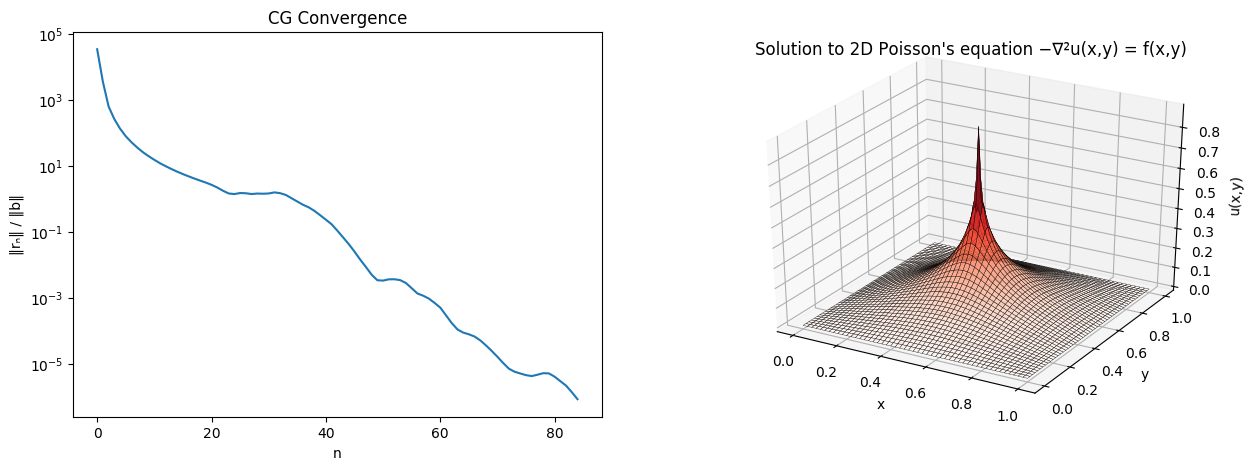

PyObject <matplotlib.text.Text object at 0x140311470>

In [22]:
# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01

A = poisson2d(∆x, ∆y, Nx, Ny)

f = zeros(Nx, Ny)
f[cld(Nx,2), cld(Ny,2)] = 1e4

b = f[:]

# Solve the equation by PCG.
CC = copy(A)
icc_poisson2d!(CC, Nx)
x = copy(b)  # x = zeros(N)
n, relres = pcg!(A, b, x, CC)

# Prepare plot data.
u = zeros(Nx+2, Ny+2)
u[2:Nx+1, 2:Ny+1] = reshape(x, (Nx,Ny))

xs = (0:Nx+1)*∆x .+ zeros(Ny+2)'
ys = (0:Ny+1)'*∆y .+ zeros(Nx+2)

# Plot the convergence behavior and the solution.
using PyPlot
figure(figsize=(15,5))

subplot(121)
semilogy(0:n, relres[1:n+1])
title("CG Convergence")
xlabel("n")
ylabel("‖rₙ‖ / ‖b‖")

PyPlot.PyObject(PyPlot.axes3D)
subplot(122, projection="3d")
plot_surface(xs, ys, u, rstride=2,edgecolors="k", cstride=2, cmap="Reds", alpha=0.8, linewidth=0.25)
title("Solution to 2D Poisson's equation −∇²u(x,y) = f(x,y)")
xlabel("x")
ylabel("y")
zlabel("u(x,y)")

### Assignment B.2.  Benefit of preconditioning [1 pt]

Our current `pcg!` is suboptimal, but in principle we could optimize `pcg!` by implementing efficient routines for $C^{-*} v$ and $C^{-1} v$.  We want to know if such optimization is worth the effort.

For the same 2D Poisson's equation with $N_x = N_y = 99$ that has been repeatedly solved in the previous validation code blocks, answer if the benifit of using the incomplete Cholesky factors as the preconditioners is none, significant, or marginal.

***Solution.***

In CG and preconditioned CG, the most expensive parts in each iteration step are evaluation of $A p$ and $C^{-1} A C^{-*} p$, respectively.  Because the number of nonzero entries in $C$ is about a half the number of nonzero entries in $A$, application of $C^{-1}$ or $C^{-*}$ to a vector by forward or back substitution takes about a half the work of $A p$.  Therefore, evaluation of $C^{-1} A C^{-*} p$ takes about $\frac{1}{2} + 1 + \frac{1}{2} = 2$ times as much work as evaluation of $A p$.

Now, we observe that `cg!` and `pcg!` take about 200 and 80 iteration steps, respectively, to solve the same problem.  Because each iteration step in `pcg!` is about twice more expensive than each iteartion step in `cg!`, this is about $\frac{200}{80\times 2} \approx 1.25$ times improvement in time.  On top of this, if we also consider extra time taken for creating the preconditioner, this is only a marginal improvement. 

As demonstrated here, general-purpose preconditioners such as the incomplete Cholesky factors often lead to only a marginal improvement.  Therefore, to get a significant improvement by preconditioning, we have to develop preconditioners tailored for the specific problem (Poisson's equation in this case).